In [ ]:
import argparse
import os
import sys 
sys.path.insert(0, '/raven/u/noka/VAEEG')  # or use relative: os.path.abspath('..')
from src.model.opts.dataset import ClipDataset
from src.model.net.old_modelA import VAEEG, re_parameterize
import yaml
import torch
import numpy as np
import umap
from collections import OrderedDict
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def load_model(model: nn.Module, ckpt_file: str):
    """
    Loads a checkpoint saved from single- or multi-GPU training into a model
    running on a single GPU or CPU. Returns any auxiliary info found.
    """
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    ckpt = torch.load(ckpt_file, map_location=device)
    sd = ckpt["model"]

    # Remove "module.", if saved under DataParallel/DDP"
    if next(iter(sd)).startswith("module."):
        sd = {k[len("module."):]: v for k, v in sd.items()}
    model.load_state_dict(sd)
    model.to(device)
    
    return device

In [3]:
def init_model(in_channels, z_dim, deterministic, ckpt_file, negative_slope=0.2, decoder_last_lstm=False): 
    model = VAEEG(in_channels=in_channels,
                    z_dim=z_dim,
                    negative_slope=negative_slope,
                    decoder_last_lstm=decoder_last_lstm,
                    deterministic=deterministic)
    device = load_model(model, ckpt_file=ckpt_file)
    return model, device

In [4]:
def get_latent(model, loader, device, z_dim):
    model.eval()
    num_samples = len(loader.dataset)
    z_arr = np.zeros((num_samples, z_dim), dtype=np.float32)  
    idx = 0
    encoder = model.module.encoder if hasattr(model, 'module') else model.encoder
    # Get the deterministic setting from the model
    deterministic = model.module.deterministic if hasattr(model, 'module') else model.deterministic
    with torch.no_grad():
        for x in loader:
            x = x.to(device)
            mu, log_var = encoder(x)
            if deterministic:
                z_batch = mu  # In deterministic mode, log_var is None, so just use mu
            else:
                z_batch = re_parameterize(mu, log_var, deterministic=deterministic)
            bs = z_batch.size(0)
            z_arr[idx:idx + bs, :] = z_batch.cpu().numpy()
            idx += bs
    return z_arr

In [5]:
def init_dl(data_root, band, batch_size=1024, num_workers=1, shuffle=False): 
    # Dataloader for this band
    ds = ClipDataset(
        data_dir=data_root,
        band_name=band, 
        clip_len=256
    )
    loader = DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
    )
    return loader

In [10]:
# Define model parameters
bands = ["delta", "theta", "alpha", "low_beta", "high_beta"]
z_dim = 50
epoch = 37
in_channels=1
seed = 42 
deterministic = True
if deterministic: 
    ckpt_root = "/raven/u/noka/VAEEG/models_new/vanilla"
else: 
    ckpt_root = "/raven/u/noka/VAEEG/models_new/variational/"
data_dir = "/ptmp/noka/new_data/"

In [7]:
# Dictionaries for latents
ae_latents = {} 
vae_latents = {}
pca_latents = {}
pca_train = {}
pca_test = {}

In [8]:
# Prepare data for PCA fitting
rng_test = np.random.RandomState(seed)
starts_test = rng_test.randint(0, 1280 - 256 + 1, size=288182)
rng_train = np.random.RandomState(seed)
starts_train = rng_train.randint(0, 1280 - 256 + 1, size=2575060)
for band in tqdm(bands): 
    band_train = np.load(os.path.join(data_dir, "train", f"{band}.npy"))
    band_test = np.load(os.path.join(data_dir, "test", f"{band}.npy"))
    orig_train = np.zeros((band_train.shape[0], 256), dtype=band_train.dtype)
    orig_test = np.zeros((band_test.shape[0], 256), dtype=band_test.dtype)
    for i in range(band_train.shape[0]):
        orig_train[i] = band_train[i, starts_train[i]:starts_train[i] + 256]
    for i in range(band_test.shape[0]):
        orig_test[i] = band_test[i, starts_test[i]:starts_test[i] + 256]
    pca_train[band] = orig_train
    pca_test[band] = orig_test

100%|██████████| 5/5 [00:41<00:00,  8.37s/it]


In [11]:
# Get AE and VAE latents
for band in tqdm(bands):
    ckpt_file = os.path.join(ckpt_root, band, f"z{z_dim}", f"ckpt_epoch_{epoch}.ckpt")
    model, device = init_model(in_channels=in_channels, z_dim=z_dim, deterministic=deterministic, ckpt_file=ckpt_file)
    loader = init_dl(os.path.join(data_dir, "test"), band)
    latent = get_latent(model=model, loader=loader, device=device, z_dim=z_dim)
    if deterministic: 
        ae_latents[band] = latent
    else: 
        vae_latents[band] = latent

100%|██████████| 5/5 [00:17<00:00,  3.59s/it]


In [22]:
# Get PCA latents
for band in tqdm(bands):
    data_train = pca_train[band]   
    pca = PCA(n_components=2, random_state=42)
    pca.fit(data_train)
    print("Explained variance ratio sum:", np.sum(pca.explained_variance_ratio_))
    data_test = pca_test[band]     
    latents = pca.transform(data_test)
    pca_latents[band] = latents

 20%|██        | 1/5 [00:00<00:02,  1.49it/s]

Explained variance ratio sum: 0.48739028


 40%|████      | 2/5 [00:01<00:02,  1.49it/s]

Explained variance ratio sum: 0.31405157


 60%|██████    | 3/5 [00:02<00:01,  1.48it/s]

Explained variance ratio sum: 0.4700768


 80%|████████  | 4/5 [00:02<00:00,  1.48it/s]

Explained variance ratio sum: 0.42942685


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

Explained variance ratio sum: 0.40121025


In [12]:
# extract seizure and background indices 
labels = np.load("/ptmp/noka/labels/test.npy")

In [13]:
seiz_indices = np.where(labels == 1)[0]
bkgd_indices = np.where(labels == 0)[0]

In [23]:
pca_vae = {}
pca_ae = {}

In [44]:
# Get PCA projections
for band in tqdm(bands):
    pca = PCA(n_components=2, random_state=42)
    proj = pca.fit_transform(ae_latents[band])
    print(pca.explained_variance_ratio_) 
    pca_ae[band] = proj

100%|██████████| 5/5 [00:00<00:00, 47.51it/s]

[0.19691148 0.171343  ]
[0.12007035 0.11174095]
[0.13139898 0.12513147]
[0.88789934 0.01732478]
[0.96203387 0.00239898]


In [31]:
pca.explained_variance_ratio_

array([0.96203387, 0.00239898], dtype=float32)

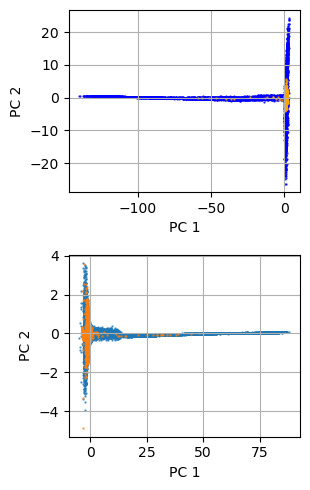

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(3.2, 5))

# Background points
axes[0].scatter(pca_ae["low_beta"][labels == 0, 0],
           pca_ae["low_beta"][labels == 0, 1],
           alpha=0.7, marker='.', s=2, label="Background", color="blue")

# Seizure points
axes[0].scatter(pca_ae["low_beta"][labels == 1, 0],
           pca_ae["low_beta"][labels == 1, 1],
           alpha=0.7, marker='.', s=2, label="Seizure", color="orange")
axes[0].set_xlabel('PC 1')
axes[0].set_ylabel('PC 2')
axes[0].grid(True)



# Background points
axes[1].scatter(pca_ae["high_beta"][labels == 0, 0],
           pca_ae["high_beta"][labels == 0, 1],
           alpha=0.7, marker='.', s=2, label="Background")

# Seizure points
axes[1].scatter(pca_ae["high_beta"][labels == 1, 0],
           pca_ae["high_beta"][labels == 1, 1],
           alpha=0.7, marker='.', s=2, label="Seizure")
axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2')
axes[1].grid(True)

plt.tight_layout()
plt.savefig("pca_on_vae_latents.pdf")
plt.show()

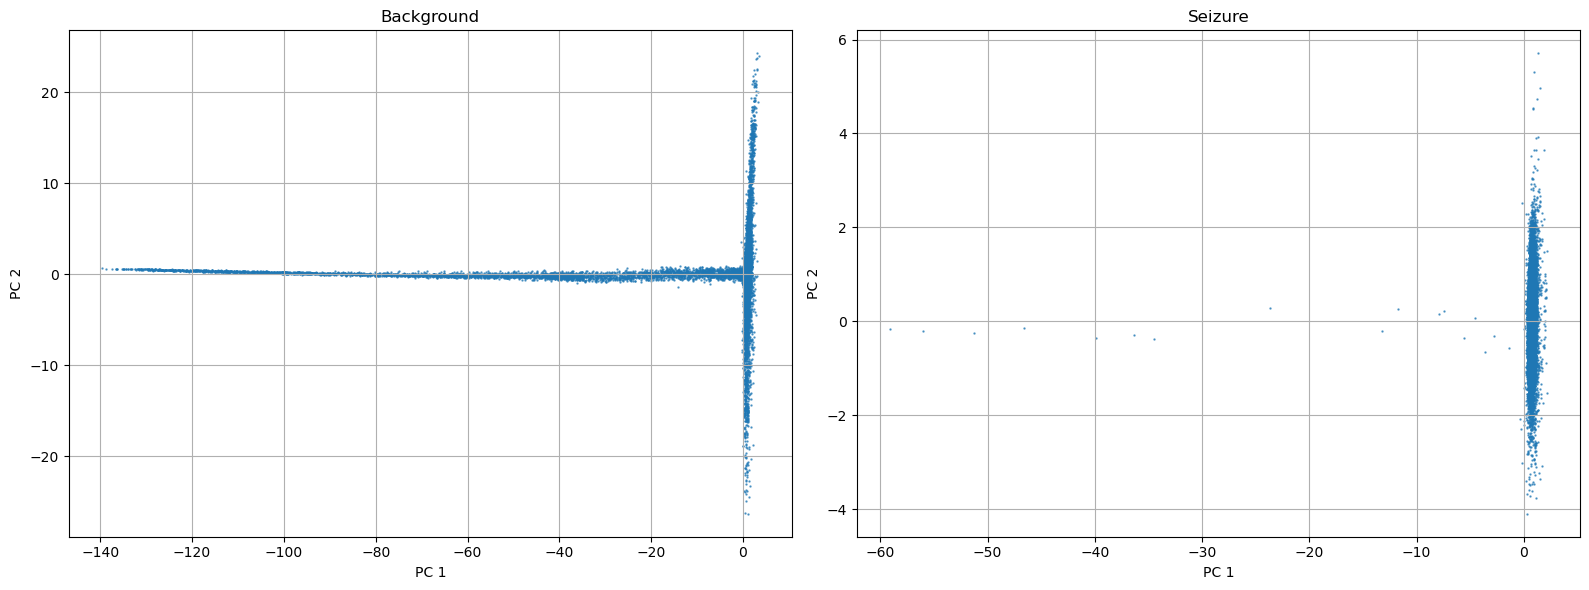

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Background points
axes[0].scatter(pca_ae["low_beta"][labels == 0, 0],
                pca_ae["low_beta"][labels == 0, 1],
                alpha=0.7, marker='.', s=2, label="Background")
axes[0].set_xlabel('PC 1')
axes[0].set_ylabel('PC 2')
axes[0].set_title('Background')
axes[0].grid(True)

# Seizure points
axes[1].scatter(pca_ae["low_beta"][labels == 1, 0],
                pca_ae["low_beta"][labels == 1, 1],
                alpha=0.7, marker='.', s=2, label="Seizure")
axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2')
axes[1].set_title('Seizure')
axes[1].grid(True)


plt.tight_layout()
plt.show()